In [1]:
import numpy as np
import tables as tb
import matplotlib.pyplot as plt

from sklearn.neighbors import KDTree
from astropy.cosmology import Planck15 as cosmo

from scipy.integrate import quad
from scipy.interpolate import interp1d

from numpy.random import default_rng

## Read mock data (flux-limited)

In [2]:
mockfname = 'aspec_mock_hr4.hdf5'
h5file = tb.open_file(mockfname,"r")
agl   = h5file.root.RA.read()
agb   = h5file.root.Dec.read()
azred = h5file.root.zred.read()
aMKs  = h5file.root.MKs.read()
aKs   = h5file.root.Ks.read()
h5file.close()
fskyASPEC = 1

# Let's measure the angular 2pcf

## Binning

Divide the sample with equal signal-to-noise bin

In [3]:
azarr = np.linspace(0.05,0.15,num=50)
Nculm = [len(azred[azred<zmaxthis]) for zmaxthis in azarr]
fzculmN = interp1d(Nculm,azarr,kind=1)

Nbin   = 12
Ntotal = Nculm[-1]
aNculm = [(Ntotal/Nbin)*ithis for ithis in range(1,Nbin+1)]

azcut = [0.05]
for Nculm in aNculm:
    zcut_this = fzculmN(Nculm)
    azcut.append(zcut_this)
    print("{0:.3f}: {1:.0f}".format(zcut_this, Nculm))

azcut = np.array(azcut)
print(azcut)

0.055: 72090
0.061: 144180
0.066: 216270
0.072: 288359
0.077: 360449
0.084: 432539
0.090: 504629
0.098: 576719
0.106: 648808
0.116: 720898
0.129: 792988
0.150: 865078
[0.05       0.05549426 0.06073306 0.06593421 0.07169322 0.07737282
 0.08361569 0.09025217 0.09759047 0.10610306 0.11613217 0.12906311
 0.15      ]


0.050 - 0.055: 72240
0.055 - 0.061: 71744
0.061 - 0.066: 72507
0.066 - 0.072: 71537
0.072 - 0.077: 72667
0.077 - 0.084: 71816
0.084 - 0.090: 72069
0.090 - 0.098: 72079
0.098 - 0.106: 72290
0.106 - 0.116: 72075
0.116 - 0.129: 72004
0.129 - 0.150: 72050


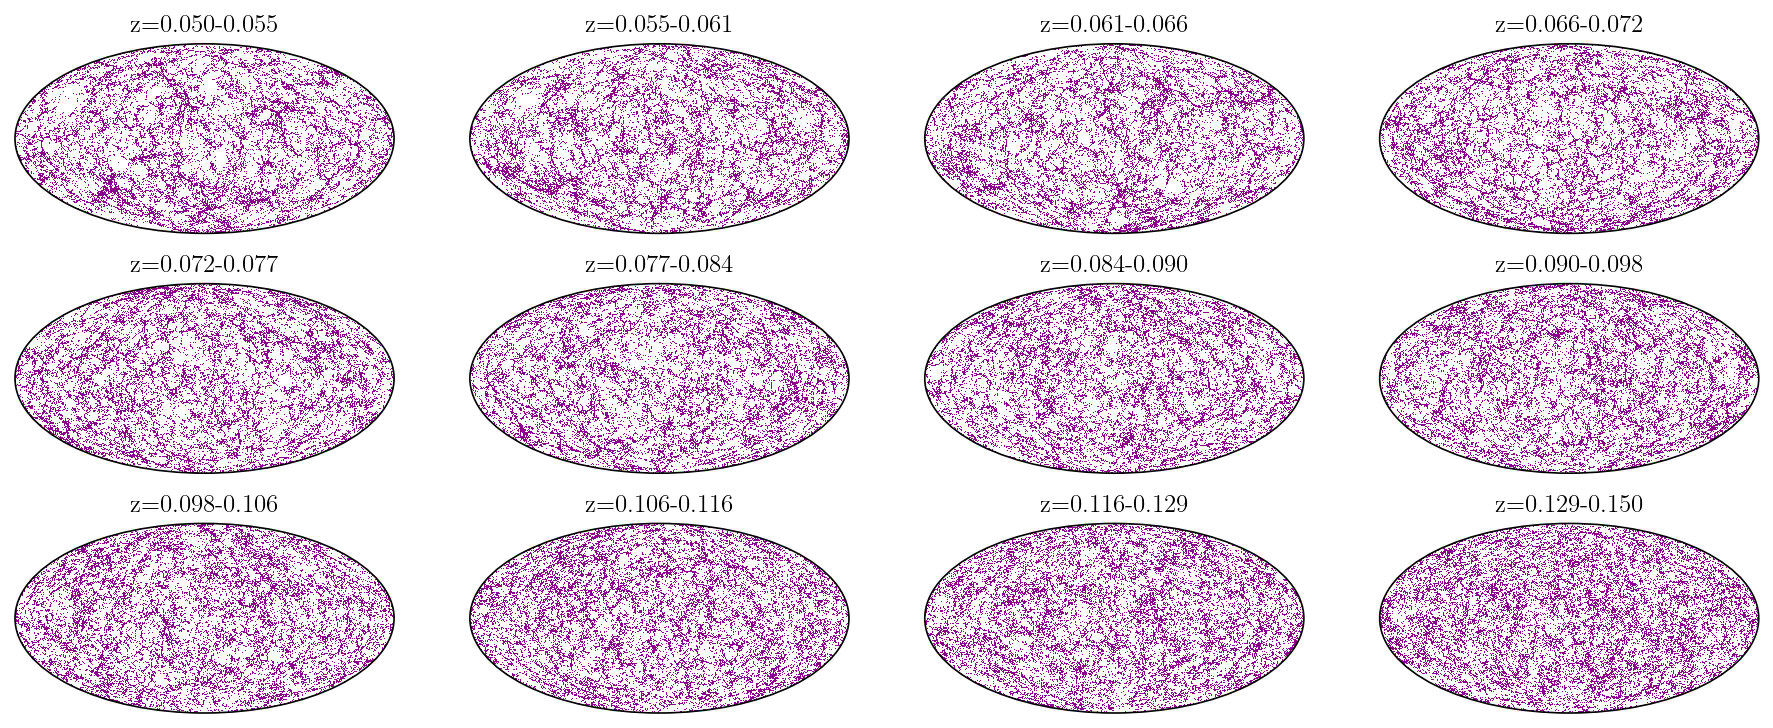

In [4]:
radian = np.pi/180
xshow = agl*radian
mm = agl > 180
xshow[mm] = xshow[mm] - 2*np.pi
yshow = agb*radian

azarr = azcut #np.linspace(0.05,0.15,num=11) #[0.05,0.1,0.15]
fig = plt.figure(figsize=(15,6),dpi=150)

for zindx in range(12):
    zmin_this = azarr[zindx]
    zmax_this = azarr[zindx+1]
    ax  = fig.add_subplot(3,4,zindx+1,projection="mollweide")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True,alpha=1)
    mz = (azred>zmin_this)*(azred<=zmax_this) #*(np.abs(yshow)>10*np.pi/180)
    print("{0:.3f} - {1:.3f}: {2:d}".format(zmin_this,zmax_this,np.sum(mz)))
    ax.scatter(xshow[mz],yshow[mz],marker=",",s=0.1,c="DarkMagenta",ec=None)
    ax.set_title("z={:.3f}".format(zmin_this)+"-{:.3f}".format(zmax_this),fontsize=12)
plt.savefig("Aspec2.png")

## From angle to xyz coordinate (In order to use the usual metric)

In [4]:
radian = np.pi/180
def vec3d(gl,gb):
    theta = (90-gb)*radian
    phi = gl*radian
    xy = np.sin(theta)
    x = np.array(xy * np.cos(phi))
    y = np.array(xy * np.sin(phi))
    z = np.cos(theta)
    return np.stack((x,y,z),axis=-1)

In [5]:
zindx = 0 
zmin_this = azcut[zindx]
zmax_this = azcut[zindx+1]
zmask = (azred>zmin_this)*(azred<=zmax_this)

nxyz = vec3d(agl[zmask],agb[zmask])

## On array manipulation in python 

In [57]:
ndata = len(nxyz)
from numpy import dot
from numpy import histogram
from numpy import array

mu_min = -1
mu_max = 1
Nmubins = 10

def dot_histo_slowest(indx1):
    mu_this = []
    for indx2 in range(indx1,ndata):
        dot12 = 0.0
        for indx kin range(3):
            dot12 += (nxyz[indx1,indx]*nxyz[indx2,indx])
        mu_this.append(dot12)
                       
    muhist, mubins = histogram(mu_this,bins=Nmubins,range=(mu_min,mu_max))
    return muhist

def dot_histo_slow(indx1):
    mu_this = array([nxyz[indx1,:].dot(nxyz[indx2,:]) for indx2 in range(indx1,ndata)])
    muhist, mubins = histogram(mu_this,bins=Nmubins,range=(mu_min,mu_max))
    return muhist

def dot_histo_fast(indx1):
    mu_this = array(nxyz[indx1,:].dot(nxyz[indx1:ndata,:].T))
    muhist, mubins = histogram(mu_this,bins=Nmubins,range=(mu_min,mu_max))
    return muhist

In [58]:
%%time
indx=0
histo = np.zeros(Nmubins)

histo = histo + dot_histo_fast(indx)
histo

CPU times: user 3.85 ms, sys: 1.53 ms, total: 5.38 ms
Wall time: 5.13 ms


array([6697., 6599., 9202., 7726., 6981., 7301., 6180., 6428., 8525.,
       6601.])

In [59]:
%%time
indx=0
histo = np.zeros(Nmubins)

histo = histo + dot_histo_slow(indx)
histo

CPU times: user 142 ms, sys: 5.63 ms, total: 147 ms
Wall time: 169 ms


array([6697., 6599., 9202., 7726., 6981., 7301., 6180., 6428., 8525.,
       6601.])

In [60]:
%%time
indx=0
histo = np.zeros(Nmubins)

histo = histo + dot_histo_slowest(indx)
histo

CPU times: user 210 ms, sys: 6.75 ms, total: 217 ms
Wall time: 245 ms


array([6697., 6599., 9202., 7726., 6981., 7301., 6180., 6428., 8525.,
       6601.])

In [61]:
%%time
histo = np.zeros(Nmubins)
for indx in range(ndata):
    histo = histo + dot_histo_slowest(indx)

CPU times: user 1h 27min 28s, sys: 15.8 s, total: 1h 27min 44s
Wall time: 1h 28min 19s


In [62]:
%%time
histo = np.zeros(Nmubins)
for indx in range(ndata):
    histo = histo + dot_histo_fast(indx)

CPU times: user 1min 50s, sys: 2.3 s, total: 1min 53s
Wall time: 1min 28s




## Calculating the angular 2pcf

Relation between 3D distance r and angular distance d: 
$r^2 = 2(1-cos(d))$

In [6]:
def d2r(d):
    # d in degree
    return np.sqrt(2*(1-np.cos(d*np.pi/180)))

Defining the bin

In [7]:
darr = np.linspace(0,40,num=401)
ar = d2r(darr)

Make the randomly distributed points (R), then alculate RR pairs

In [8]:
%%time

#Nrandom = 2000000
Nrandom = 200000
seed = 9582512
rng = default_rng(seed)
aRmu  = rng.random(size=Nrandom)*2.0 - 1.0
aRphi = rng.random(size=Nrandom)*2.0*np.pi

def vec3dR(mu,phi):
    xy = np.sqrt(1-mu**2)
    x = np.array(xy * np.cos(phi))
    y = np.array(xy * np.sin(phi))
    z = mu
    return np.stack((x,y,z),axis=-1)

aRxyz = vec3dR(aRmu,aRphi)
RRtree = KDTree(aRxyz)
count_RR = RRtree.two_point_correlation(aRxyz,ar)
RR = np.diff(count_RR)/2

CPU times: user 7min 42s, sys: 4.69 s, total: 7min 47s
Wall time: 8min 6s


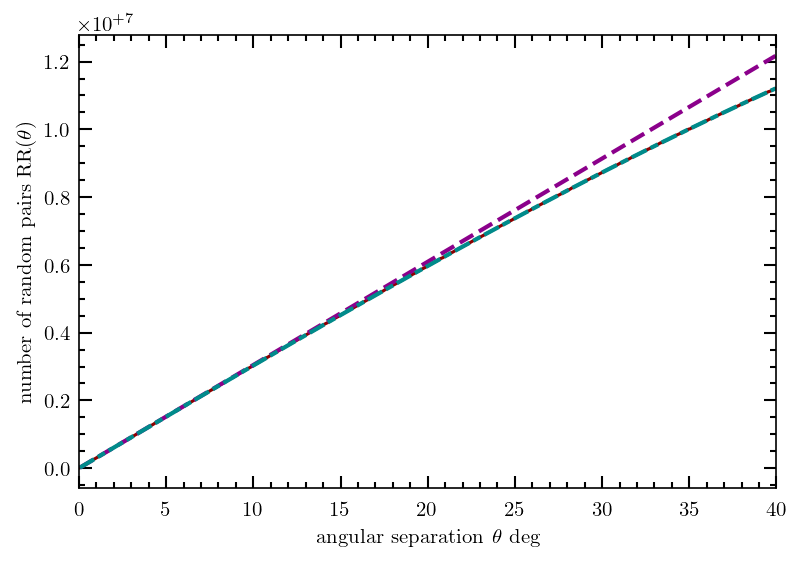

In [9]:
darrC = (darr[1:]+darr[:-1])/2
Ddarr = darr[2]-darr[1]
radian = np.pi/180
RRest = Nrandom**2/4*darrC*Ddarr*radian**2
RRest2 = Nrandom**2/4*np.sin(darrC*radian)*Ddarr*radian
RRest3 = Nrandom**2/4*(np.cos(darrC*radian)-np.cos(darrC*radian+Ddarr*radian))

fig = plt.figure(figsize=(6,4),dpi=150)
ax = fig.add_subplot(111)
ax.set_xlim([0,40])
#ax.set_ylim([475000,620000])
ax.set_xlabel("angular separation $\\theta$ deg")
ax.set_ylabel("number of random pairs RR($\\theta$)")
ax.plot(darrC,RR,c="DarkRed")
ax.plot(darrC,RRest,c="DarkMagenta",lw=2,ls="--")
ax.plot(darrC,RRest2,c="DarkCyan",lw=2,ls="--",dashes=(4,1,2,1))
fig.savefig("RRtheta_zoom.png")

In [10]:
radian = np.pi/180
def RRuniform(Nsample,atheta,Dtheta):
    return Nsample**2/4*np.sin(atheta*radian)*Dtheta*radian

0
1
2
3
4
5
6
7
8
9
10
11
CPU times: user 24min 34s, sys: 42 s, total: 25min 16s
Wall time: 30min 38s


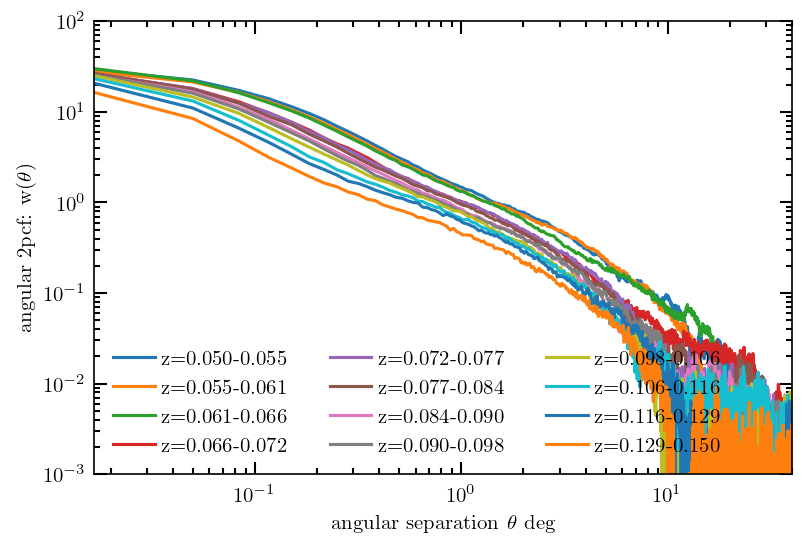

In [13]:
%%time

darr = np.linspace(0,40,num=1201)
darrC = (darr[1:]+darr[:-1])/2
Ddarr = darr[2]-darr[1]
ar = d2r(darr)

axi = []
aDD = []

fig = plt.figure(figsize=(6,4),dpi=150)
ax = fig.add_subplot(111)
ax.set_xlim([np.min(darrC),40])
ax.set_ylim([1e-3,100])
ax.set_xlabel("angular separation $\\theta$ deg")
ax.set_ylabel("angular 2pcf: w($\\theta$)")
ax.set_xscale("log")
ax.set_yscale("log")

for zindx in range(len(azcut)-1):
    print(zindx)
    zmin_this = azcut[zindx]
    zmax_this = azcut[zindx+1]
    # select galaxies in this binj
    zmask = (azred>zmin_this)*(azred<=zmax_this)
    # find 3D coordinate on sphere
    nxyz = vec3d(agl[zmask],agb[zmask])
    Ndata = len(nxyz)
    
    tree = KDTree(nxyz)
    count_DD = tree.two_point_correlation(nxyz,ar)
    DD = np.diff(count_DD)/2
    aDD.append(DD)
    xi = DD/RRuniform(Ndata,darrC,Ddarr) - 1
    axi.append(xi)
    ax.plot(darrC,xi,label="z={:.3f}-{:.3f}".format(zmin_this,zmax_this))
    
ax.legend(loc="lower left",ncol=3)
fig.savefig("xitheta.png")

np.savetxt("aspec_mock_DD.dat",aDD)
np.savetxt("aspec_mock_xi.dat",axi)

In [85]:
aDD = np.loadtxt("aspec_mock_DD.dat")
axi = np.loadtxt("aspec_mock_xi.dat")

0
1
2
3
4
5
6
7
8
9
10
11
CPU times: user 848 ms, sys: 85.6 ms, total: 933 ms
Wall time: 2.34 s


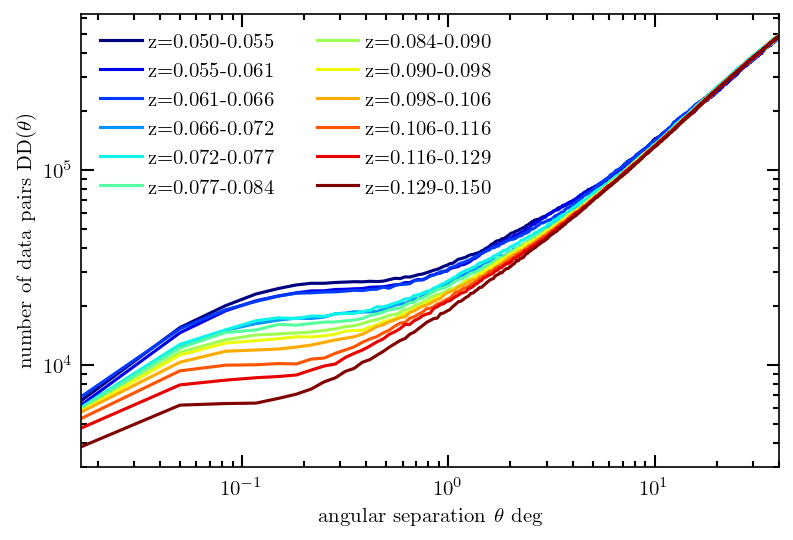

In [69]:
%%time

darr = np.linspace(0,40,num=1201)
darrC = (darr[1:]+darr[:-1])/2
Ddarr = darr[2]-darr[1]
ar = d2r(darr)


colors = plt.cm.jet(np.linspace(0,1,len(azcut)-1))

fig = plt.figure(figsize=(6,4),dpi=150)
ax = fig.add_subplot(111)
ax.set_xlim([np.min(darrC),40])
#ax.set_ylim([1e-3,10])
ax.set_xlabel("angular separation $\\theta$ deg")
ax.set_ylabel("number of data pairs DD($\\theta$)")
ax.set_xscale("log")
ax.set_yscale("log")

for zindx in range(len(azcut)-1):
    print(zindx)
    zmin_this = azcut[zindx]
    zmax_this = azcut[zindx+1]
    # select galaxies in this binj
    zmask = (azred>zmin_this)*(azred<=zmax_this)
    # find 3D coordinate on sphere
    nxyz = vec3d(agl[zmask],agb[zmask])
    Ndata = len(nxyz)
    
    DD = aDD[zindx]
    ax.plot(darrC,DD,c=colors[zindx],label="z={:.3f}-{:.3f}".format(zmin_this,zmax_this))
    
    zcent = (zmin_this+zmax_this)/2
    thetaBAO = 106/littleh/frz(zcent)*180/np.pi
    
    #ax.plot([thetaBAO,thetaBAO],[-10,10],":",c=colors[zindx])
    
    
ax.legend(loc="upper left",ncol=2)
fig.savefig("DD.png")

0
1
2
3
4
5
6
7
8
9
10
11
CPU times: user 692 ms, sys: 49.1 ms, total: 741 ms
Wall time: 980 ms


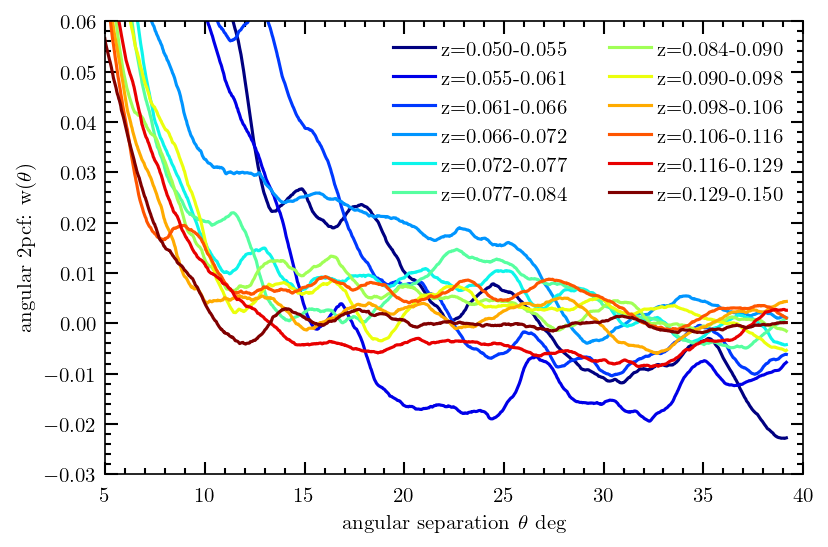

In [78]:
%%time

darr = np.linspace(0,40,num=1201)
darrC = (darr[1:]+darr[:-1])/2
Ddarr = darr[2]-darr[1]
ar = d2r(darr)


colors = plt.cm.jet(np.linspace(0,1,len(azcut)-1))

fig = plt.figure(figsize=(6,4),dpi=150)
ax = fig.add_subplot(111)
ax.set_xlim([5,40])
ax.set_ylim([-0.03,0.06])
ax.set_xlabel("angular separation $\\theta$ deg")
ax.set_ylabel("angular 2pcf: w($\\theta$)")
ax.set_xscale("linear")
ax.set_yscale("linear")

for zindx in range(len(azcut)-1):
    print(zindx)
    zmin_this = azcut[zindx]
    zmax_this = azcut[zindx+1]
    # select galaxies in this binj
    zmask = (azred>zmin_this)*(azred<=zmax_this)
    # find 3D coordinate on sphere
    nxyz = vec3d(agl[zmask],agb[zmask])
    Ndata = len(nxyz)
    
    xi = axi[zindx]
    width=50
    x_smooth = np.convolve(darrC,np.ones(width),'valid')/width
    xi_smooth = np.convolve(xi,np.ones(width),'valid')/width
    ax.plot(x_smooth,xi_smooth,c=colors[zindx],label="z={:.3f}-{:.3f}".format(zmin_this,zmax_this))
    
    zcent = (zmin_this+zmax_this)/2
    thetaBAO = 106/littleh/frz(zcent)*180/np.pi
    
    #ax.plot([thetaBAO,thetaBAO],[-10,10],":",c=colors[zindx])
    
    
ax.legend(loc="upper right",ncol=2)
fig.savefig("xi_largeT.png")

0
1
2
3
4
5
6
7
8
9
10
11
CPU times: user 857 ms, sys: 53.5 ms, total: 910 ms
Wall time: 1.06 s


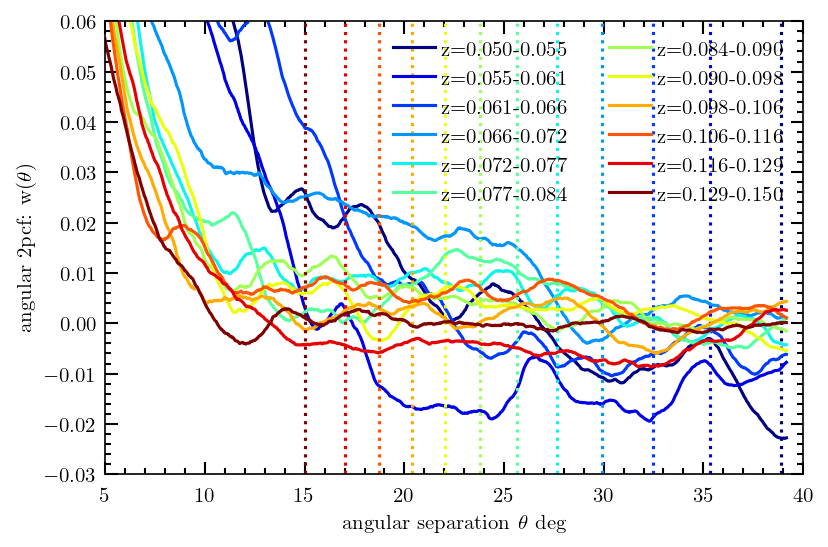

In [80]:
%%time

darr = np.linspace(0,40,num=1201)
darrC = (darr[1:]+darr[:-1])/2
Ddarr = darr[2]-darr[1]
ar = d2r(darr)


colors = plt.cm.jet(np.linspace(0,1,len(azcut)-1))

fig = plt.figure(figsize=(6,4),dpi=150)
ax = fig.add_subplot(111)
ax.set_xlim([5,40])
ax.set_ylim([-0.03,0.06])
ax.set_xlabel("angular separation $\\theta$ deg")
ax.set_ylabel("angular 2pcf: w($\\theta$)")
ax.set_xscale("linear")
ax.set_yscale("linear")

for zindx in range(len(azcut)-1):
    print(zindx)
    zmin_this = azcut[zindx]
    zmax_this = azcut[zindx+1]
    # select galaxies in this binj
    zmask = (azred>zmin_this)*(azred<=zmax_this)
    # find 3D coordinate on sphere
    nxyz = vec3d(agl[zmask],agb[zmask])
    Ndata = len(nxyz)
    
    xi = axi[zindx]
    width=50
    x_smooth = np.convolve(darrC,np.ones(width),'valid')/width
    xi_smooth = np.convolve(xi,np.ones(width),'valid')/width
    ax.plot(x_smooth,xi_smooth,c=colors[zindx],label="z={:.3f}-{:.3f}".format(zmin_this,zmax_this))
    
    zcent = (zmin_this+zmax_this)/2
    thetaBAO = 106/littleh/frz(zcent)*180/np.pi
    
    ax.plot([thetaBAO,thetaBAO],[-10,10],":",c=colors[zindx])
    
    
ax.legend(loc="upper right",ncol=2)
fig.savefig("xi_largeT_BAO.png")

0
1
2
3
4
5
6
7
8
9
10
11
CPU times: user 675 ms, sys: 34.7 ms, total: 710 ms
Wall time: 772 ms


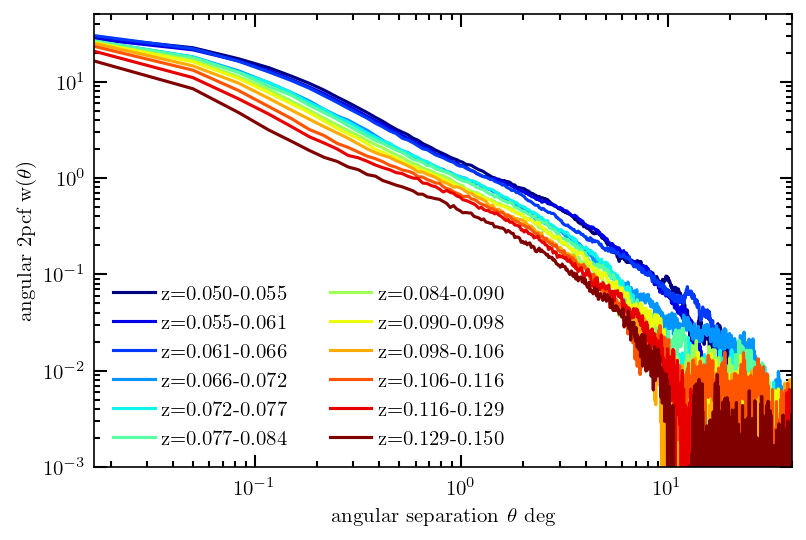

In [74]:
%%time

darr = np.linspace(0,40,num=1201)
darrC = (darr[1:]+darr[:-1])/2
Ddarr = darr[2]-darr[1]
ar = d2r(darr)


colors = plt.cm.jet(np.linspace(0,1,len(azcut)-1))

fig = plt.figure(figsize=(6,4),dpi=150)
ax = fig.add_subplot(111)
ax.set_xlim([np.min(darrC),40])
ax.set_ylim([1e-3,50])
ax.set_xlabel("angular separation $\\theta$ deg")
ax.set_ylabel("angular 2pcf w($\\theta$)")
ax.set_xscale("log")
ax.set_yscale("log")

for zindx in range(len(azcut)-1):
    print(zindx)
    zmin_this = azcut[zindx]
    zmax_this = azcut[zindx+1]
    # select galaxies in this binj
    zmask = (azred>zmin_this)*(azred<=zmax_this)
    # find 3D coordinate on sphere
    nxyz = vec3d(agl[zmask],agb[zmask])
    Ndata = len(nxyz)
    
    xi = axi[zindx]
    width=1
    x_smooth = np.convolve(darrC,np.ones(width),'valid')/width
    xi_smooth = np.convolve(xi,np.ones(width),'valid')/width
    ax.plot(x_smooth,xi_smooth,c=colors[zindx],label="z={:.3f}-{:.3f}".format(zmin_this,zmax_this))
    
    zcent = (zmin_this+zmax_this)/2
    thetaBAO = 106/littleh/frz(zcent)*180/np.pi
    
    #ax.plot([thetaBAO,thetaBAO],[-10,10],":",c=colors[zindx])
    
    
ax.legend(loc="lower left",ncol=2)
fig.savefig("xi.png")

## Cosmology to get the BAO scale

Calculate and tabulated the angular diameter distance, luminnosity distance, Hubble, etc.

In [24]:
zmin = 0.05; zmax = 0.15;
littleh = cosmo.h
print("h=",littleh)
Vaspec = (cosmo.comoving_volume(zmax) - cosmo.comoving_volume(zmin))
print("Volume of Aspec={0:.4f} Gpc^3".format(Vaspec.value/1e9))

h= 0.6774
Volume of Aspec=1.0553 Gpc^3


In [25]:
chimax = cosmo.comoving_distance(zmax).value
print("r max={:.4f} Mpc".format(chimax))

r max=640.1968 Mpc


In [27]:
zarr  = np.linspace(zmin,zmax,num=200)
chiarr = cosmo.comoving_distance(zarr).value
DLarr = cosmo.luminosity_distance(zarr).value
frz  = interp1d(zarr,chiarr,kind=1)

Plot the distance

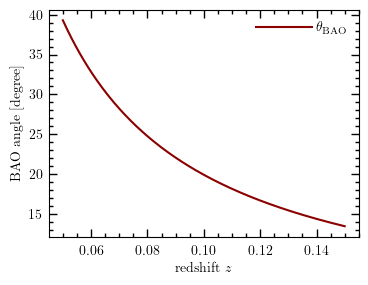

In [83]:
fig = plt.figure(figsize=(4,3),dpi=100)
ax = fig.add_subplot(111)
ax.set_xlabel("redshift $z$")
ax.set_ylabel("BAO angle [degree]")
ax.plot(zarr,150/chiarr*180/np.pi,c="DarkRed",label="$\\theta_{\\rm BAO}$")
ax.legend(loc="upper right",handlelength=4)
plt.savefig("thetaBAO.png")